In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report


In [2]:
df=pd.read_csv('hotel_train.csv')

In [3]:
df_test=pd.read_csv('hotel_test.csv')

In [4]:
example=pd.read_csv('example.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109390 entries, 0 to 109389
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Unnamed: 0                      109390 non-null  int64  
 1   hotel                           109390 non-null  object 
 2   is_canceled                     109390 non-null  int64  
 3   lead_time                       109390 non-null  int64  
 4   arrival_date_year               109390 non-null  int64  
 5   arrival_date_month              109390 non-null  object 
 6   arrival_date_week_number        109390 non-null  int64  
 7   arrival_date_day_of_month       109390 non-null  int64  
 8   stays_in_weekend_nights         109390 non-null  int64  
 9   stays_in_week_nights            109390 non-null  int64  
 10  adults                          109390 non-null  int64  
 11  children                        109386 non-null  float64
 12  babies          

#### Проверим пропуски в данных

In [6]:
def miss(df):
    for col in df:
        if df[col].isnull().sum()>0:
            a=df[col].isnull().sum()
            print(f' столбец {col} содержит {a} пропусков')
    print('больше нет!')

In [8]:
miss(df_test)

 столбец country содержит 48 пропусков
 столбец agent содержит 1353 пропусков
 столбец company содержит 9440 пропусков
больше нет!


In [9]:
miss(df)

 столбец children содержит 4 пропусков
 столбец country содержит 440 пропусков
 столбец agent содержит 14987 пропусков
 столбец company содержит 103153 пропусков
больше нет!


In [74]:
#удаляем все пропуски
#также удаляем столбец company, так как пропусков слишком много
df.drop(columns='company', inplace=True)
df['agent'] = df['agent'].fillna(0)
df['country'] = df['country'].fillna('Unknown')
#подавляющее большинство значения равны нулю; заменим пропуски на ноли.
df['children'] = df['children'].fillna(0)

In [75]:
# посмотрим на значения children
df.children.value_counts()

0.0     101513
1.0       4467
2.0       3342
3.0         67
10.0         1
Name: children, dtype: int64

In [76]:
miss(df)

больше нет!


Пропусков больше нет. 
Далее можео провести небольшой разведочный анализ данных.

In [77]:
#Созададим общий признак дети
df['kids']=df['babies']+df['children']
df.drop(['babies','children'], axis=1, inplace=True)

In [78]:
#Создадим общий признак количество дней, вошедших в период бронирования
df['total_stay']=df['stays_in_weekend_nights']+df['stays_in_week_nights']
df.drop(['stays_in_weekend_nights','stays_in_week_nights'], axis=1, inplace=True)

## Разведочный анализ

In [79]:
#проверим наличие дубликатов
df.duplicated().sum()

0

In [80]:
#посмотрим на данные
df.describe()

,Unnamed: 0,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,adults,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,kids,total_stay
count,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000,109390.000000
mean,54694.500000,0.370619,103.962309,2016.156733,27.176086,15.793665,1.856221,0.031840,0.085739,0.136795,0.221227,74.859539,2.295173,101.848380,0.062391,0.572210,0.111811,3.428549
std,31578.317311,0.482973,106.830264,0.706818,13.607950,8.787948,0.583035,0.175575,0.821513,1.494938,0.653251,107.125415,17.475652,50.770693,0.245319,0.792711,0.412281,2.558170
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000,0.000000
25%,27347.250000,0.000000,18.000000,2016.000000,16.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,69.372500,0.000000,0.000000,0.000000,2.000000
50%,54694.500000,0.000000,69.000000,2016.000000,28.000000,16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,94.500000,0.000000,0.000000,0.000000,3.000000
75%,82041.750000,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,152.000000,0.000000,126.000000,0.000000,1.000000,0.000000,4.000000
max,109389.000000,1.000000,737.000000,2017.000000,53.000000,31.000000,55.000000,1.000000,26.000000,72.000000,21.000000,535.000000,391.000000,5400.000000,8.000000,5.000000,10.000000,69.000000


In [81]:
#В данных есть отрицательный adr, так скорее всего быть не должно.
df.drop(df[df.adr<1.0].index,inplace=True)
# Ненужный столбец
df.drop(columns='Unnamed: 0', inplace=True)

In [82]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,meal,country,...,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,kids,total_stay
0,City Hotel,1,38,2016,June,26,19,1,BB,PRT,...,52.0,0,Transient,81.00,0,0,Canceled,2016-05-27,0.0,3
1,City Hotel,0,10,2016,November,47,13,1,BB,BEL,...,9.0,0,Transient,97.00,0,2,Check-Out,2016-11-17,0.0,4
2,City Hotel,0,246,2016,December,53,27,3,BB,ROU,...,7.0,0,Transient,93.36,0,2,Check-Out,2017-01-03,0.0,7
3,City Hotel,0,84,2015,October,42,16,2,BB,NOR,...,8.0,0,Transient,89.25,0,2,Check-Out,2015-10-19,0.0,3
4,Resort Hotel,0,50,2016,November,49,29,2,BB,GBR,...,314.0,0,Transient,44.99,0,1,Check-Out,2016-12-06,0.0,7


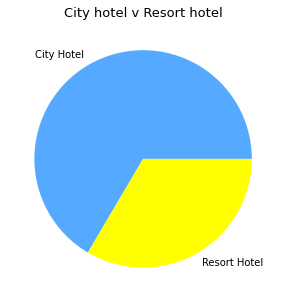

In [83]:
labels = df.hotel.value_counts().index
sizes = df.hotel.value_counts()
plt.figure(figsize = (5,5))
plt.pie(sizes, labels=labels,colors=['#55AAFF','yellow'])
plt.title('City hotel v Resort hotel',color = 'black',fontsize = 13);

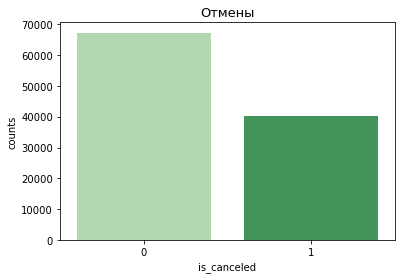

In [84]:
counts = df.is_canceled.value_counts()
counts.sort_index(inplace=True)
sns.barplot(x = counts.index, y = counts,palette='Greens')
plt.xlabel('is_canceled')
plt.ylabel('counts')
plt.title('Отмены',color = 'black',fontsize = 13);

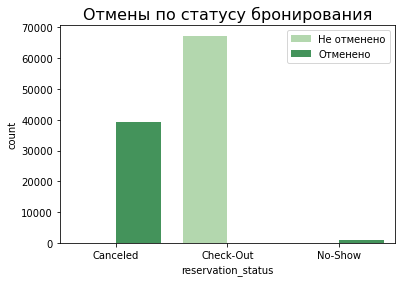

In [85]:
sns.countplot(data=df, x = 'reservation_status',hue='is_canceled',palette='Greens')
plt.title("Отмены по статусу бронирования",fontsize=16)
plt.legend(['Не отменено','Отменено'])
plt.show()

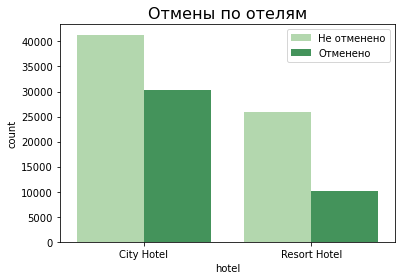

In [86]:
sns.countplot(data=df, x = 'hotel',hue='is_canceled',palette='Greens')
plt.title("Отмены по отелям",fontsize=16)
plt.legend(['Не отменено','Отменено'])
plt.show()

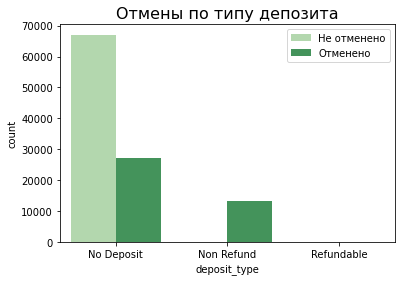

In [87]:
sns.countplot(data=df, x = 'deposit_type',hue='is_canceled',palette='Greens')
plt.title("Отмены по типу депозита",fontsize=16)
plt.legend(['Не отменено','Отменено'])
plt.show()

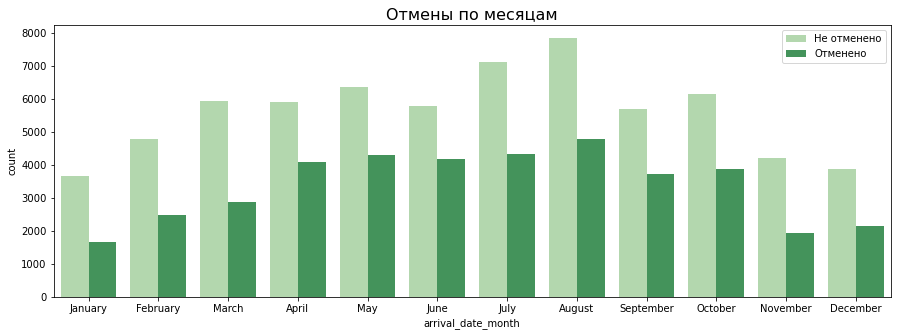

In [88]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x = 'arrival_date_month',hue='is_canceled',palette='Greens',order=["January","February","March","April","May","June","July","August","September","October","November","December"])
plt.title("Отмены по месяцам",fontsize=16)
plt.legend(['Не отменено','Отменено'])
plt.show()

#### Категориальные данные

In [89]:
#Посмотрим категориальные данные
cate = df.select_dtypes(include='object')
for i in cate:
    print(i , df[i].nunique())

hotel 2
arrival_date_month 12
meal 5
country 176
market_segment 8
distribution_channel 5
reserved_room_type 9
assigned_room_type 11
deposit_type 3
customer_type 4
reservation_status 3
reservation_status_date 921


In [90]:
# дата установки статуса определяется как объект, переведем в дату.
df['reservation_status_date']=pd.to_datetime(df['reservation_status_date'])

In [91]:
#переведем reservation_status_date в отдельные столбцы и удалим сам признак
df['reservation_status_year'] = df['reservation_status_date'].dt.year
df['reservation_status_month'] = df['reservation_status_date'].dt.month
df['reservation_status_day'] = df['reservation_status_date'].dt.day
df.drop(columns='reservation_status_date', inplace=True)

In [92]:
a = df.select_dtypes(object).columns
cat_list = []
for i in a:
    print (i, df[i].nunique())
    cat_list.append(i)

hotel 2
arrival_date_month 12
meal 5
country 176
market_segment 8
distribution_channel 5
reserved_room_type 9
assigned_room_type 11
deposit_type 3
customer_type 4
reservation_status 3


In [93]:
#Закодируем категориальные переменные
le=LabelEncoder()
for i in cat_list:
    df[i] = le.fit_transform(df[i])
df['reservation_status_year'] = le.fit_transform(df['reservation_status_year'])
df['reservation_status_month'] = le.fit_transform(df['reservation_status_month'])
df['reservation_status_day'] = le.fit_transform(df['reservation_status_day'])

In [94]:
#Удалим статус бронирования, так как он практически полностью копирует результирующий признак
df.drop(['arrival_date_year','reservation_status'], axis = 1, inplace=True)

### Повтор действий с df_test

In [95]:
#удаляем все пропуски
#также удаляем столбец company, так как пропусков слишком много
df_test.drop(columns='company', inplace=True)
df_test['agent'] = df_test['agent'].fillna(0)
df_test['country'] = df_test['country'].fillna('Unknown')
#подавляющее большинство значения равны нулю; заменим пропуски на ноли.
df_test['children'] = df_test['children'].fillna(0)

In [96]:
#Созададим общий признак дети
df_test['kids']=df_test['babies']+df_test['children']
df_test.drop(['babies','children'], axis=1, inplace=True)
#Создадим общий признак количество дней, вошедших в период бронирования
df_test['total_stay']=df_test['stays_in_weekend_nights']+df_test['stays_in_week_nights']
df_test.drop(['stays_in_weekend_nights','stays_in_week_nights'], axis=1, inplace=True)


In [97]:
# Ненужный столбец
df_test.drop(columns='Unnamed: 0', inplace=True)

In [98]:
# дата установки статуса определяется как объект, переведем в дату.
df_test['reservation_status_date']=pd.to_datetime(df_test['reservation_status_date'])
#переведем reservation_status_date в отдельные столбцы и удалим сам признак
df_test['reservation_status_year'] = df_test['reservation_status_date'].dt.year
df_test['reservation_status_month'] = df_test['reservation_status_date'].dt.month
df_test['reservation_status_day'] = df_test['reservation_status_date'].dt.day
df_test.drop(columns='reservation_status_date', inplace=True)

In [99]:
b = df_test.select_dtypes(object).columns
cat_list_test = []
for i in b:
    print (i, df_test[i].nunique())
    cat_list_test.append(i)

hotel 2
arrival_date_month 12
meal 5
country 108
market_segment 7
distribution_channel 4
reserved_room_type 10
assigned_room_type 11
deposit_type 3
customer_type 4
reservation_status 3


In [100]:
#Закодируем категориальные переменные
le=LabelEncoder()
for i in cat_list_test:
    df_test[i] = le.fit_transform(df_test[i])
df_test['reservation_status_year'] = le.fit_transform(df_test['reservation_status_year'])
df_test['reservation_status_month'] = le.fit_transform(df_test['reservation_status_month'])
df_test['reservation_status_day'] = le.fit_transform(df_test['reservation_status_day'])

In [101]:
#Удалим статус бронирования, так как он практически полностью копирует результирующий признак
df_test.drop(['arrival_date_year','reservation_status'], axis = 1, inplace=True)

#### Объединим общую с тестовой выборкой

объединим, чтобы стандартизировать и потом обратно разделим

In [102]:
df_c=pd.concat([df,df_test])

In [103]:
df_c.drop('is_canceled', axis=1, inplace=True)

In [104]:
#Стандартизация
scaler = StandardScaler()
df_std = scaler.fit_transform(df_c)

Разделим обратно

In [105]:
y = df['is_canceled']

In [106]:
X_std=df_std[:len(df)]
df_test=df_std[len(df):]

#### Разделеление

In [107]:
#Разделение
X_train, X_test, y_train, y_test = train_test_split(X_std,y,random_state=123,test_size=0.3)

#### Логистическая модель

In [108]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
log_proba = log_reg.predict_proba(X_test)
log_auc=cross_val_score(log_reg, X_train, y_train, cv=5, scoring='roc_auc').mean()
log_auc

0.866955836840695

#### Деревья решений

In [109]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_proba = clf.predict_proba(X_test)
clf_auc=cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc').mean()
clf_auc

0.9335934272049325

#### Случайный лес

In [110]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_auc=cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc').mean()
rfc_auc

0.9867727142606713

In [111]:
rfc_proba = rfc.predict_proba(X_test)

#### KNeighbors

In [112]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_auc=cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc').mean()
knn_auc

0.9372381868366204

In [113]:
knn_proba = knn.predict_proba(X_test)

##### График ROC-AUC

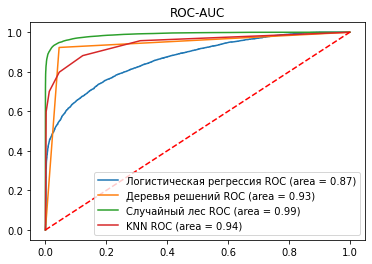

In [114]:
plt.figure()
models = [
{
    'label': 'Логистическая регрессия',
    'auc': log_auc,
    'proba':log_proba
},
{
    'label': 'Деревья решений',
    'auc': clf_auc,
    'proba': clf_proba
},
{
    'label': 'Случайный лес',
    'auc': rfc_auc,
    'proba': rfc_proba
},
{
    'label': 'KNN',
    'auc': knn_auc,
    'proba': knn_proba
}
    
]
for m in models:
    fpr, tpr, thresholds = roc_curve(y_test, m['proba'][:,1])
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], m['auc']))
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC-AUC')
plt.legend(loc="lower right")

###### Поробуем подобрать лучшие параметры, для случайного леса

In [115]:
rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}


In [116]:
rf_random = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=rf_params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 15, None],
                                        'max_features': [5, 7, 'auto'],
                                        'min_samples_split': [2, 8, 15, 20],
                                        'n_estimators': [100, 200, 500, 1000]},
                   verbose=2)

In [117]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'max_features': 7,
 'max_depth': None}

In [118]:
rfc = RandomForestClassifier(n_estimators=1000,
 min_samples_split=2,
 max_features=7,
 max_depth=None)
rfc.fit(X_train, y_train)
rfc_auc=cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc').mean()
rfc_auc

0.988860619753353

#### Предсказание на тестовой выборке

In [119]:
rfc_proba_test = rfc.predict_proba(df_test)

In [120]:
rfc_proba_test[:,1]

array([0.074, 0.115, 0.821, ..., 0.742, 0.126, 0.911])

In [121]:
f_out = pd.DataFrame({"Вероятность": rfc_proba_test[:,1]})
f_out

,Вероятность
0,0.074
1,0.115
2,0.821
3,0.003
4,0.140
...,...
9995,0.957
9996,0.787
9997,0.742
9998,0.126


In [123]:
f_out.to_csv('result.csv')